In [1]:
import xarray as xr
from glob import glob
import dask
import os
import shutil
import numpy as np
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt
import zarr
from dask.diagnostics import ProgressBar

%matplotlib inline

In [2]:
zarr.__version__

'2.2.1.dev125'

In [3]:
xr.__version__

'0.13.0'

### Optional: Use a Dask Cluster

If the computer where you are producing the dataset can provide parallelism, it can speed things up a lot to use a dask cluster. Even if you are only using a small machine, using a distributed cluster is nice because it gives you lots of useful diagnostics and progress information via the dashboard.

For reference, the machine where this example was run is a large shared server with 36 Xeon CPU cores, 1TB of RAM, and ~400 TB of RAID-6 hard disk storage.

### Open Source NetCDF Files

Rather than using globbing to find the source files, here I am being more explicit about which files I want to open. This is recommended if know the pattern and conventions that were used to produce the source files.

In [4]:
experiment = 'control'
base_dir = '/swot/SUM01/CM2.6'
ddir = os.path.join(base_dir, experiment)
prefix = 'ocean'
year_start, year_end = 181, 200
years = np.arange(year_start, year_end+1)
year_str = '%04d-%04d' % (year_start, year_end)
files = [os.path.join(ddir, '%04d0101.%s.nc' % (year, prefix))
         for year in years]

Here I define some more options related to opening the files. Specifically, I know I want to drop certain extraneous coordinates and auxilliary variables. 

**Performance tip:** Dropping coordinates when opening many files with xarray is generally a good idea, because xarray has to verify that the coordinates are identical in each file. The coordinates can then be added back to the concattenated dataset.

In [5]:
# these are variables I just want to drop forever
drop_vars = ['average_T1', 'average_T2', 'average_DT', 'time_bounds']
#drop_vars += ['yt_ocean', 'xt_ocean', 'yu_ocean', 'xu_ocean',
#              'grid_yu_ocean', 'grid_xu_ocean', 'grid_yt_ocean', 'grid_xt_ocean']
# therse are variables I want to drop while running `open_mfdataset` but then add back later
#extra_coord_vars = ['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c']

chunks = {'time': 'auto', 'st_ocean': 5}

#open_kwargs = dict(drop_variables=(drop_vars + extra_coord_vars),
#dsets = [xr.open_dataset(f, chunks=chunks, decode_times=False) for f in files]


open_kwargs = dict(compat='override', coords='minimal', combine='by_coords',
                   chunks=chunks, decode_cf=True, decode_times=False)
ds = xr.open_mfdataset(files, parallel=True, **open_kwargs)

# add the extra coordinates back in
#ds0 = xr.open_dataset(files[0], decode_cf=True, decode_times=False)[extra_coord_vars]
#for cv in extra_coord_vars:
#    ds.coords[cv] = ds0.coords[cv]
ds

<xarray.Dataset>
Dimensions:            (nv: 2, st_edges_ocean: 51, st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50, time: 240, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
    geolat_c           (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * st_edges_ocean     (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * xt_ocean           (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * st_ocean           (st_ocean) float64 5.034 15.1 ... 5.185e+03 5.395e+03
  * time               (time) float64 6.576e+04 6.579e+04 ... 7.3e+04 7.303e+04
  * yt_ocean           (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * nv                 (nv) float64 1.0 2.0
  * sw_edges_ocean     (sw_edges_ocean) float64 5.034 15.1 ... 5.395e+03 5.5e+03
    geolon_c           (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t           (yt_ocean, xt_ocean) float32 dask.array<chunks

Do a sanity check on the input data.

/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


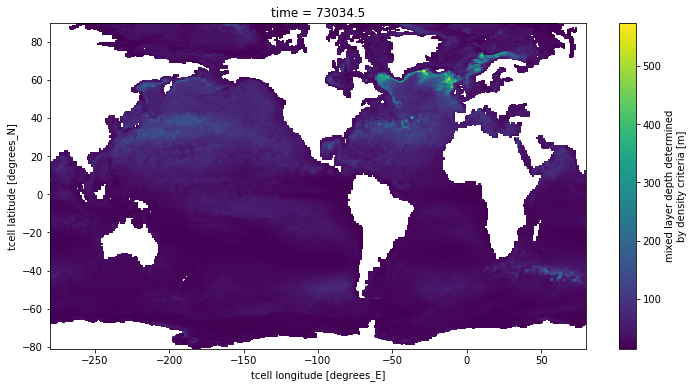

In [6]:
ds.mld[-1].coarsen(yt_ocean=10, xt_ocean=10).mean().load().plot(figsize=(12, 6))

### Export to Zarr

I also define a custom compressor to use.

In [7]:
compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=2)
encoding = {vname: {'compressor': compressor} for vname in ds.variables}
outdir_base = '/swot/SUM03/tmp/CM2.6'
dsname = prefix
outdir = os.path.join(outdir_base, experiment, dsname)
outdir

'/swot/SUM03/tmp/CM2.6/control/ocean'

In [ ]:
ds.nbytes / 1e9

3909.928433952

In [ ]:
with ProgressBar():
    zs = ds.to_zarr(outdir, encoding=encoding, consolidated=True)

[#                                       ] | 4% Completed | 14min 14.8s

### Verify Zarr Dataset

In [ ]:
ds_z = xr.open_zarr(outdir, consolidated=True)
ds_z

In [ ]:
ds_z.mld[-1].coarsen(yt_ocean=10, xt_ocean=10).mean().load().plot(figsize=(12, 6))

Look at zarr's own diagnostic info for one of the variables. There is lots of useful info in here.

In [ ]:
zstore = zs.ds
zstore.temp.info